In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from glove import *
import myUtils

import pandas as pd
from pandas.io.json._normalize import nested_to_record
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn import metrics
from sklearn import svm

**Load GloVe model and dataset**

In [3]:
glove_model = GloveModel.from_pretrained('../trained_models/el.glove.300.txt')

In [4]:
review_dict = myUtils.read_json_v2('../data/reviews_revision.json')
reviews = pd.DataFrame.from_dict(nested_to_record(review_dict, sep='_'))

reviews.drop(columns=['_id_$oid', 'meta_product_name'], inplace=True)

**Get embeddings from tokens using GloVe model**

In [5]:
reviews['embeddings'] = reviews['text'].apply(glove_model.string_to_embeddings)
reviews['embeddings_length'] = reviews['embeddings'].apply(len)

Word "δυκολεψε" doesn't exist in the vocabulary
Word "παλιομοδητης" doesn't exist in the vocabulary
Word "αγγγλικα" doesn't exist in the vocabulary
Word "``" doesn't exist in the vocabulary
Word "``" doesn't exist in the vocabulary
Word "menou" doesn't exist in the vocabulary
Word "ξεπατηκωμενο" doesn't exist in the vocabulary
Word "μονοκαμερο" doesn't exist in the vocabulary
Word "ανταπoκρινεται" doesn't exist in the vocabulary
Word "``" doesn't exist in the vocabulary
Word "``" doesn't exist in the vocabulary
Word "σελιδασ" doesn't exist in the vocabulary
Word "roborock" doesn't exist in the vocabulary
Word "cleanner" doesn't exist in the vocabulary
Word "workaround" doesn't exist in the vocabulary
Word "wcwfteizfw" doesn't exist in the vocabulary
Word "κλησω" doesn't exist in the vocabulary
Word "γρατζουνιεται" doesn't exist in the vocabulary
Word "boses" doesn't exist in the vocabulary
Word "χρειαστειται" doesn't exist in the vocabulary
Word "gcam" doesn't exist in the vocabulary
W

**Remove outliers (entries with very long length)**

In [7]:
q_hi = reviews['embeddings_length'].quantile(0.95)
reviews = reviews[reviews['embeddings_length'] < q_hi].reset_index(drop=True)

In [8]:
reviews['embeddings_length'].describe()

count    756.000000
mean      68.503968
std       49.414331
min        5.000000
25%       32.000000
50%       54.000000
75%       95.250000
max      227.000000
Name: embeddings_length, dtype: float64

**Find mean vector for each review**

In [9]:
def v_mean(vectors):
    temp_sum = np.sum(vectors, axis=0)
    return temp_sum / np.linalg.norm(temp_sum)

In [10]:
reviews['embeddings_mean'] = reviews['embeddings'].apply(v_mean)

In [11]:
reviews.sample(5)

,text,meta_product_type,meta_review_sentiment,meta_review_pros,meta_review_so-so,meta_review_cons,embeddings,embeddings_length,embeddings_mean
264,Εκτος του οτι για να συνδεθει με το xiaomi κιν...,Smartwatches,positive,"[Ακρίβεια μετρήσεων, Οθόνη, Αυτονομία μπαταρίας]",[],[Συγχρονισμός],"[[0.0407911598729903, -0.03406602486115794, -0...",60,"[0.048527315412105886, -0.044076136638576575, ..."
26,Δεν έμεινα ικανοποιημένη από το κινητο 1. Δεν ...,Κινητά Τηλέφωνα,negative,[],[],"[Ηχείο, Μπαταρία, Ταχύτητα]","[[0.051004380667544, -0.10801070325827683, -0....",109,"[0.05087130094476932, -0.021515386459546017, 0..."
504,Πεταμένα λεφτά.Συνεχη κολλήματα.Κακιστη αγορά.,Κινητά Τηλέφωνα,negative,[],[],"[Ταχύτητα, Σχέση ποιότητας τιμής]","[[0.10126456452152173, -0.022253867364246234, ...",9,"[0.03130076255658072, 0.011624400491383467, 0...."
512,Είναι πολύ καλο έχει Πολύ ωραία κάμερα,Κινητά Τηλέφωνα,positive,"[Φωτογραφίες, Καταγραφή Video]",[],[],"[[0.05034098502912862, -0.026742241838596758, ...",7,"[-0.0073337894870019954, -0.008634994452445675..."
295,Πολύ καλή εικόνα και ήχος αγορά 569 ευρώ Δεν έ...,Τηλεοράσεις,neutral,"[Εικόνα, Ήχος]",[],[Μενού],"[[0.013351956677592808, -0.020389052063867617,...",83,"[0.029845995990316915, -0.023677639197190455, ..."


**Train-Test split**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
                np.array(list(reviews[['embeddings_mean']].values.squeeze()), dtype=np.float32),
                reviews['meta_review_sentiment'].values, test_size=0.25, random_state=0)

 **Grid search for RBF kernel SVM parameters**

In [13]:
C_range = np.logspace(0, 7, 8)
gamma_range = np.logspace(-7, 0, 8)
param_grid = dict(gamma=gamma_range, C=C_range)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, scoring='f1_weighted', cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %2.2f"
      % (grid.best_params_, grid.best_score_*100))

The best parameters are {'C': 1000000.0, 'gamma': 1e-06} with a score of 58.06


**Draw heatmap of the validation accuracy as a function of gamma and C**

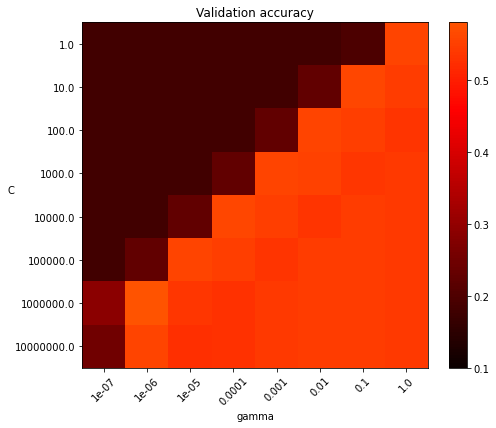

In [36]:
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.1, midpoint=0.59))
plt.xlabel('gamma')
plt.ylabel('C', rotation='horizontal')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

**Train model with best parameters**

In [15]:
svm_model = svm.SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
svm_model.fit(X_train, y_train)

SVC(C=1000000.0, gamma=1e-06)

In [16]:
y_pred = svm_model.predict(X_test)

In [17]:
print('Confusion matrix\n')
print(metrics.confusion_matrix(y_test, y_pred))
print('\n')

print(metrics.classification_report(y_test, y_pred))

Confusion matrix

[[49 13  8]
 [21 23 18]
 [12  9 36]]


              precision    recall  f1-score   support

    negative       0.60      0.70      0.64        70
     neutral       0.51      0.37      0.43        62
    positive       0.58      0.63      0.61        57

    accuracy                           0.57       189
   macro avg       0.56      0.57      0.56       189
weighted avg       0.56      0.57      0.56       189

